# Information Detection from Trade Data

<b> YouTube Tutorial </b> (Published: Jun 13, 2023): https://youtu.be/OF230bS6yo8

## Background

### The Goal:
Identify information based trading activity.

<b>What does that mean?</b>

Informed traders of good news will profit by buying while traders with bad news will profit by selling.

### Motivation: Why we Care?

According to market microstructure models, trade data has historically played a key role because of its signal value for underlying private information [1].

For example, trade imbalance between buys and sells can signal liquidity pressue and lead to subsequent price movements. This can be cause by informed traders transacting in large volumes. Therefore, we want to detect informative trade flow!

By identifying informed trading activity, this can help characterise investor behaviour and participants / market makers can adjust accordingly.

Though information detection is of primary importance, aggressor-signing can be useful as well for assessing trading costs, and an ideal algorithm should do both [2].

### Traditional Approaches:

In the past, emphasis was placed on attempting to identify individual trade's aggressor: in other words, was this trade initiated by the buyer or the seller. Some exchanges make this information available within their data streams, but many do not.

The established methods, most notably the algorithms of Lee and Ready (1991) (LR), Ellis et al. (2000) (EMO) and Chakrabarty et al. (2007) (CLNV), classify trades based on the proximity of the transaction price to the quotes in effect at the time of the trade.

In today's market, this is problematic due to the increased frequency of order submission and cancellation, across many exchanges.

### Problem:

The complications of using these historical algorithms to assess the agressor side of trading is very difficult in the world of high frequency markets.

In the new world of electronic markets, there are:
- complex order types: for example hidden orders
- market fragmentation: trading is split across many exchanges and alternative trading venues. These appear on the consolidated tape but at different latencies.
- high frequency of order cancellations: as much as up to 98% [1] therefore complicating actual quotes at time of trades
- complex order execution algorithms:
        -- execution algorithms that can chop "parent orders" into numerous "child" orders distribute them across exchanges with different order types

In summary trades on the consolidated tape can be out of order and with order cancellation rates up to 98% this complicates knowing actual quotes at the time of trades.

Trade classification algorithms that rely on the following, can be severly compromised:
- rules based on up-ticks or down-ticks
- proximity to bid and ask quotes

Both research papers Easley et al. (2016) [1] and Panayides et al.(2019) [2] found that traditional algorithms that find individual trade agressor no longer captures information.
- Traditional algorithms fail to explain the dynamics, of spreads or prices over time.
- This suggests that the other sources of buying (or selling) pressure ignored by the tick rule are so important that the tick rule does not succeed in detecting the informational
content carried by the order flow. (sourced: directly from [1])

### Solution:

Easley et al. (2012) created the Bulk Volume Classification (BVC) algorithm, which instead of classifying individual trades, aggregates trades by volume or ticks to then infer the buying and selling activity within these collective groups of trades. The BVC algorithm therefore focussing on classification of aggregated trade flows, which both [1] & [2] have found to be better linked to proies of informed-based trading.

Because BVC uses the market makers’ aggregated response to order flow to infer its informational content, it overcomes these limitations of the tick rule and
provides a new tool for discerning the presence of underlying information from market data (sourced: directly from [1]).

Both [1] & [2] find that BVC can identify trade aggressors as well as traditional algorithms, and its signed order flow is the only measure that is reliably related to different illiquidity measures shown to capture the trading intensions of informed traders.

### Methodology: Scientific Method [1] & [2] - only for those interested:

Theory in market microstructure predicts that with more informed trading, liquidity is affected as market makers widen spreads to protect themselves [2].

Easley et al. (2012) therefore argued that if an algorithm is capturing underlying information, then absolute order imbalance should be positively related to spread in bar $\tau$ [2].

Both [1] & [2] ran regression on various spread estimates on estimated order imbalance and lagged spread estimates:

$\large Spread_\tau = \alpha_0 + \alpha_1 [Spread_{\tau-1}] + \gamma [\hat{OI}_\tau] +\epsilon_\tau$

where estimated absolute order imbalance ($\hat{OI}_\tau$) is defined as:

$\large |\hat{OI}_\tau| = |\frac{\hat{V}_\tau^B - \hat{V}_\tau^S}{V_\tau}| = |2 \frac{\hat{V}_\tau^B}{V_\tau} - 1 |$

and $\hat{V}_\tau^B$ and $\hat{V}_\tau^S$ are estimated buy and sell volumes respectively within a bar $\tau$

### Our AIM:

Implement the BVC algorithm using ThetaData historical data.

In future videos, I plan to adapt this to include realtime streaming assessment. Also I plan on creating a series that focuses on developing a market making trading bot that can could incorperate this information as a risk managment strategy.

<b>References:</b>

[1] [Easley, D., López de Prado, M. M., O’Hara, M., 2016. Discerning Information from Trade Data. Journal of Financial Economics 120,2 269-285.](https://www.sciencedirect.com/science/article/abs/pii/S0304405X16000246)

[2] [Panayides, Marios A. and Panayides, Marios A. and Shohfi, Thomas and Smith, Jared D., Bulk Volume Classification and Information Detection (April 14, 2019). Journal of Banking & Finance, Vol. 103, pp. 113-129, 2019](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2503628)

In [ ]:
import os
import time
import pickle

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import timedelta, datetime, date
from thetadata import ThetaClient, OptionReqType, OptionRight, StockReqType, DateRange, DataType, TradeCondition, Exchange

## 1. Getting the Data

ThetaData is an incredible API where we can request realtime streaming of NBBO options data, or request historical options data (trades & quotes) back for 10 years.

### 1.1 Get Option Expirations on particular Underlying

In [ ]:
from dotenv import load_dotenv
load_dotenv()

your_username = os.environ['thetadata_username']
your_password = os.environ['thetadata_password']

def get_expirations(root_ticker) -> pd.DataFrame:
    """Request expirations from a particular options root"""
    # Create a ThetaClient
    client = ThetaClient(username=your_username, passwd=your_password, jvm_mem=4, timeout=15)

    # Connect to the Terminal
    with client.connect():

        # Make the request
        data = client.get_expirations(
            root=root_ticker,
        )

    return data

In [ ]:
root_ticker = 'MSFT'
expirations = get_expirations(root_ticker)
expirations

If you require API support, feel free to join our discord server! http://discord.thetadata.us
Starting Theta Terminal [v0.9.7 REV: A]  --> Config: /Users/jonathonemerick/ThetaData/ThetaTerminal/config_0.properties
[MDDS] Attempting login as pythonforquants@gmail.com
[FPSS] Attempting login as pythonforquants@gmail.com
[FPSS] CONNECTED: [nj-a.thetadata.us:20000], Bundle: PRO, Permissions: Real-Time
[MDDS] CONNECTED: [nj-a.thetadata.us:12001], Bundle: PRO, Permissions: Real-Time


0     2012-06-01
1     2012-06-08
2     2012-06-16
3     2012-06-22
4     2012-06-29
         ...    
589   2024-06-21
590   2024-12-20
591   2025-01-17
592   2025-06-20
593   2025-12-19
Length: 594, dtype: datetime64[ns]

### 1.2 Get all Strikes for each MSFT Option Expiry

We will need these later, so I will build up a dictionary and pickle this data for future use.

In [ ]:
def get_strikes(root_ticker, expiration_dates) -> dict:
    """Request strikes from a particular option contract"""
    # Create a ThetaClient
    client = ThetaClient(username=your_username, passwd=your_password, jvm_mem=4, timeout=15)

    all_strikes = {}

    # Connect to the Terminal
    with client.connect():

        for exp_date in expiration_dates:

            # Make the request
            data = client.get_strikes(
                root=root_ticker,
                exp=exp_date
            )

            all_strikes[exp_date] = pd.to_numeric(data)


    return all_strikes

In [ ]:
root_ticker = 'MSFT'

all_strikes = get_strikes(root_ticker, expirations)

with open('MSFT_strikes.pkl', 'wb') as f:
    pickle.dump(all_strikes, f)

In [ ]:
with open('MSFT_strikes.pkl', 'rb') as f:
    all_strikes = pd.read_pickle(f)

all_strikes[expirations[360]]

0      80.0
1      85.0
2      90.0
3      95.0
4      99.0
5      99.5
6     100.0
7     101.0
8     102.0
9     103.0
10    104.0
11    105.0
12    106.0
13    107.0
14    108.0
15    109.0
16    110.0
17    111.0
18    112.0
19    113.0
20    114.0
21    115.0
22    116.0
23    117.0
24    118.0
25    119.0
26    120.0
27    121.0
28    122.0
29    123.0
30    124.0
31    125.0
32    126.0
33    127.0
34    128.0
35    129.0
36    130.0
37    131.0
38    132.0
39    133.0
40    134.0
41    135.0
42    136.0
43    137.0
44    138.0
45    139.0
46    140.0
dtype: float64

### 1.3 Pre-processing Expirations for actively traded

#### Market-Makers are not forced to show Quotes on all options!

There are rules listed for each Exchange that market makers must abide by. For Example on the NASDAQ where MSFT trades here are the [rules](https://listingcenter.nasdaq.com/rulebook/mrx/rules)

Specifically there is a large difference between the obligation of a Competitive Market Maker and the Primary Market Makers for a particular options series. This is notable in whether they need to present two-sided quotes on Non-standard options like weekly or quarterly expiry options and adjusted options.

To be safe here, we will only want to return option contracts with 'standard' option expires. These expire on the Saturday following the third Friday of the month, and some have the expiry date as the Third friday of the month, but in the past were recorded as the Saturday. Therefore we need to find the intersection of all the expiries that Thetadata has options data for and the 3rd Fridays and the following Saturday dates for every month since Jun-2021.

In [ ]:
def get_mth_expirations(expirations: pd.Series) -> pd.Series:
    trading_days = pd.date_range(start=datetime(2012,6,1),end=datetime(2023,11,14),freq='B')
    # The third friday in every month
    contracts1 = pd.date_range(start=datetime(2012,6,1),end=datetime(2024,12,31),freq='WOM-3FRI')
    # Saturday following the third friday in every month
    contracts2 = pd.date_range(start=datetime(2012,6,1),end=datetime(2022,12,31),freq='WOM-3FRI')+timedelta(days=1)
    # Combine these contracts into a total pandas index list
    contracts = contracts1.append(contracts2)
    # Find contract expiries that match with ThetaData expiries
    mth_expirations = [exp for exp in expirations if exp in contracts]
    # Convert from python list to pandas datetime
    mth_expirations = pd.to_datetime(pd.Series(mth_expirations))
    # print information of processed expiration data
    print('Number of possible monthly contracts', len(contracts), 'compared to total avail',len(mth_expirations),
      'compared to total no. options avail (incl. quarterly + weekly)', len(expirations))
    return mth_expirations

mth_expirations = get_mth_expirations(expirations)

Number of possible monthly contracts 278 compared to total avail 141 compared to total no. options avail (incl. quarterly + weekly) 594


### 1.4 Get all trade data for particular contract and strikes

Now we have a list of possiblte options contracts and their corresponding strikes.

We need a function that allows us to request trades for particular contract across a number of strikes.

In [ ]:
# Make the request
def get_option_trades(root_ticker, exp_date, strikes, start_date, end_date, interval_size=0, opt_type=OptionRight.CALL) -> pd.DataFrame:
    """Request trades for particular contract across a number of strikes"""
    # Create a ThetaClient
    client = ThetaClient(username=your_username, passwd=your_password, jvm_mem=12, timeout=30)

    # Store all iv in datas dictionary
    datas = {}

    # Connect to the Terminal
    with client.connect():

        # For each expiry we want to get closest ATM iv
        for strike in strikes:

            try:
                # Attempt to request historical options implied volatility
                data = client.get_hist_option(
                    req=OptionReqType.TRADE_QUOTE,
                    root=root_ticker,
                    exp=exp_date,
                    strike=strike,
                    right=opt_type,
                    date_range=DateRange(start_date, end_date),
                    progress_bar=False,
                    interval_size=interval_size
                )

                # Store data in dictionary
                datas[strike] = data

            except Exception as e:
                # If unavailable, store np.nan
                datas[strike] =  np.nan
                print(e)

    return datas

In [ ]:
exp_date = mth_expirations[130]
strikes = all_strikes[exp_date].tolist()

print('expiry date:\n', exp_date, '\n')
print('strikes:\n', strikes)

expiry date:
 2023-06-16 00:00:00 

strikes:
 [110.0, 115.0, 120.0, 125.0, 130.0, 135.0, 140.0, 145.0, 150.0, 155.0, 160.0, 165.0, 170.0, 175.0, 180.0, 185.0, 190.0, 195.0, 200.0, 205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0, 245.0, 250.0, 255.0, 260.0, 265.0, 270.0, 275.0, 280.0, 285.0, 290.0, 292.5, 295.0, 297.5, 300.0, 302.5, 305.0, 307.5, 310.0, 312.5, 315.0, 317.5, 320.0, 322.5, 325.0, 327.5, 330.0, 332.5, 335.0, 337.5, 340.0, 342.5, 345.0, 347.5, 350.0, 352.5, 355.0, 357.5, 360.0, 362.5, 365.0, 370.0, 375.0, 380.0, 385.0, 390.0, 395.0, 400.0, 405.0, 410.0, 415.0, 420.0, 425.0, 430.0, 435.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0, 500.0, 520.0]


In [ ]:
root_ticker = 'MSFT'
start_date = datetime(2023,1,1)
end_date = datetime(2023,6,6)

trades = get_option_trades(root_ticker, exp_date, strikes, start_date, end_date)

with open('trades.pkl', 'wb') as f:
    pickle.dump(trades, f)

In [ ]:
with open('trades.pkl', 'rb') as f:
    trades = pd.read_pickle(f)

for k, v in trades.items():
    print(k, 0 if np.isnan(v).any().any() else len(v))

110.0 62
115.0 20
120.0 25
125.0 16
130.0 5
135.0 3
140.0 26
145.0 8
150.0 54
155.0 36
160.0 23
165.0 46
170.0 56
175.0 72
180.0 101
185.0 68
190.0 75
195.0 63
200.0 442
205.0 87
210.0 186
215.0 149
220.0 472
225.0 798
230.0 1619
235.0 3537
240.0 3614
245.0 2504
250.0 5093
255.0 3244
260.0 5830
265.0 4809
270.0 7246
275.0 6617
280.0 9992
285.0 7770
290.0 9359
292.5 28
295.0 5916
297.5 27
300.0 17835
302.5 23
305.0 8474
307.5 122
310.0 15268
312.5 267
315.0 13127
317.5 1322
320.0 15042
322.5 1694
325.0 12392
327.5 2024
330.0 14201
332.5 2885
335.0 10206
337.5 2388
340.0 9540
342.5 1288
345.0 3919
347.5 1076
350.0 6027
352.5 83
355.0 1803
357.5 44
360.0 1661
362.5 23
365.0 870
370.0 1058
375.0 759
380.0 720
385.0 331
390.0 385
395.0 278
400.0 616
405.0 184
410.0 339
415.0 363
420.0 172
425.0 183
430.0 133
435.0 151
440.0 137
450.0 324
460.0 313
470.0 232
480.0 204
490.0 91
500.0 238
520.0 204


In [ ]:
trades_df = trades[300.0]
trades_df

,DataType.MS_OF_DAY,DataType.SEQUENCE,DataType.SIZE,DataType.CONDITION,DataType.PRICE,DataType.MS_OF_DAY2,DataType.BID_SIZE,DataType.BID,DataType.BID_EXCHANGE,DataType.ASK_SIZE,DataType.ASK,DataType.ASK_EXCHANGE,DataType.DATE
0,35157071,-298493043,1,18,4.35,35157071,105,4.30,5,37,4.45,9,2023-01-03
1,35386460,-263065285,1,-126,4.35,35386130,35,4.30,11,32,4.45,9,2023-01-03
2,36104551,-171014140,1,125,4.13,36104500,171,4.10,5,344,4.25,5,2023-01-03
3,37387668,-27920448,1,18,3.85,37387668,56,3.80,4,3,3.90,4,2023-01-03
4,37614792,-6773291,1,18,3.86,37614792,26,3.80,60,11,3.90,7,2023-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17830,55939905,791190806,1,18,34.55,55939905,2,34.50,4,80,34.75,65,2023-06-06
17831,56366555,822244369,1,-126,34.03,56366352,38,33.30,11,30,34.40,11,2023-06-06
17832,57316284,899262293,1,-125,34.59,57314524,30,34.00,11,30,35.20,11,2023-06-06
17833,57316284,899262295,1,-125,34.59,57314524,30,34.00,11,30,35.20,11,2023-06-06


Let's take a look at individual trades level information.

- we notice that there is a MS_OF_DAY and DATE column that we could possibly combine
- Also a Trades condition column that we would like to make more sense of

### 1.5 Data Processing

We will add some additional columns to our data such as Datetime, Trade Value and Volume Order.

In [ ]:
contract_size = 100
trades_df['DATETIME'] = trades_df[DataType.DATE] + pd.TimedeltaIndex(trades_df[DataType.MS_OF_DAY], unit='ms')
trades_df['Value'] = trades_df.apply(lambda row: row[DataType.PRICE]*row[DataType.SIZE]*contract_size, axis=1)
trades_df['Volume Order'] = trades_df[DataType.SIZE].rank(ascending=True, method='first')
trades_df.set_index('DATETIME', inplace=True)
trades_df.sort_index()

,DataType.MS_OF_DAY,DataType.SEQUENCE,DataType.SIZE,DataType.CONDITION,DataType.PRICE,DataType.MS_OF_DAY2,DataType.BID_SIZE,DataType.BID,DataType.BID_EXCHANGE,DataType.ASK_SIZE,DataType.ASK,DataType.ASK_EXCHANGE,DataType.DATE,Value,Volume Order
DATETIME,,,,,,,,,,,,,,,
2023-01-03 09:45:57.071,35157071,-298493043,1,18,4.35,35157071,105,4.30,5,37,4.45,9,2023-01-03,435.0,1.0
2023-01-03 09:49:46.460,35386460,-263065285,1,-126,4.35,35386130,35,4.30,11,32,4.45,9,2023-01-03,435.0,2.0
2023-01-03 10:01:44.551,36104551,-171014140,1,125,4.13,36104500,171,4.10,5,344,4.25,5,2023-01-03,413.0,3.0
2023-01-03 10:23:07.668,37387668,-27920448,1,18,3.85,37387668,56,3.80,4,3,3.90,4,2023-01-03,385.0,4.0
2023-01-03 10:26:54.792,37614792,-6773291,1,18,3.86,37614792,26,3.80,60,11,3.90,7,2023-01-03,386.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06 15:32:19.905,55939905,791190806,1,18,34.55,55939905,2,34.50,4,80,34.75,65,2023-06-06,3455.0,9384.0
2023-06-06 15:39:26.555,56366555,822244369,1,-126,34.03,56366352,38,33.30,11,30,34.40,11,2023-06-06,3403.0,9385.0
2023-06-06 15:55:16.284,57316284,899262293,1,-125,34.59,57314524,30,34.00,11,30,35.20,11,2023-06-06,3459.0,9386.0


### Include Trade Types  

Include ENUM names for Trade Condition Column

In [ ]:
trade_cond = {x.value : x.name for x in TradeCondition}
exchanges = {x.value[0] : x.name for x in Exchange}
trades_df['Condition'] = trades_df.apply(lambda row: trade_cond[row[DataType.CONDITION]] if row[DataType.CONDITION] in trade_cond.keys() else trade_cond[-row[DataType.CONDITION]], axis=1)
trades_df.groupby('Condition').agg({DataType.SIZE: 'sum'})

,DataType.SIZE
Condition,
AUTO_EXECUTION,57604
INTERMARKET_SWEEP,4767
OPRA_EXT_HOURS,2703
QUALIFIED_CONTINGENT_TRADE,1000
RESERVED_78,12
RESERVED_84,1391
RESERVED_878,537
RESERVED_89,1700
RESERVED_90,582


In [ ]:
trades_df['BID_EXCHANGE'] = trades_df.apply(lambda row: exchanges[row[DataType.BID_EXCHANGE]] if row[DataType.BID_EXCHANGE] in exchanges.keys() else exchanges[-row[DataType.BID_EXCHANGE]], axis=1)
trades_df['ASK_EXCHANGE'] = trades_df.apply(lambda row: exchanges[row[DataType.ASK_EXCHANGE]] if row[DataType.ASK_EXCHANGE] in exchanges.keys() else exchanges[-row[DataType.ASK_EXCHANGE]], axis=1)
trades_df.groupby(['BID_EXCHANGE']).agg({DataType.SIZE: 'sum'})

,DataType.SIZE
BID_EXCHANGE,
AMEX,1805
BATS,6405
BOST,5723
C2,7044
CBOE,23476
EDGX,9150
GEMI,695
ISEX,1213
MIAX,2893


In [ ]:
trades_df = trades_df.drop(columns=[DataType.MS_OF_DAY, DataType.MS_OF_DAY2, DataType.SEQUENCE, DataType.CONDITION, DataType.BID_EXCHANGE, DataType.ASK_EXCHANGE])
trades_df

,DataType.SIZE,DataType.PRICE,DataType.BID_SIZE,DataType.BID,DataType.ASK_SIZE,DataType.ASK,DataType.DATE,Value,Volume Order,Condition,BID_EXCHANGE,ASK_EXCHANGE
DATETIME,,,,,,,,,,,,
2023-01-03 09:45:57.071,1,4.35,105,4.30,37,4.45,2023-01-03,435.0,1.0,AUTO_EXECUTION,CBOE,PHIL
2023-01-03 09:49:46.460,1,4.35,35,4.30,32,4.45,2023-01-03,435.0,2.0,SINGLE_LEG_AUCTION_ISO,BOST,PHIL
2023-01-03 10:01:44.551,1,4.13,171,4.10,344,4.25,2023-01-03,413.0,3.0,SINGLE_LEG_AUCTION_NON_ISO,CBOE,CBOE
2023-01-03 10:23:07.668,1,3.85,56,3.80,3,3.90,2023-01-03,385.0,4.0,AUTO_EXECUTION,AMEX,AMEX
2023-01-03 10:26:54.792,1,3.86,26,3.80,11,3.90,2023-01-03,386.0,5.0,AUTO_EXECUTION,BATS,PACF
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06 15:32:19.905,1,34.55,2,34.50,80,34.75,2023-06-06,3455.0,9384.0,AUTO_EXECUTION,AMEX,EDGX
2023-06-06 15:39:26.555,1,34.03,38,33.30,30,34.40,2023-06-06,3403.0,9385.0,SINGLE_LEG_AUCTION_ISO,BOST,BOST
2023-06-06 15:55:16.284,1,34.59,30,34.00,30,35.20,2023-06-06,3459.0,9386.0,SINGLE_LEG_AUCTION_NON_ISO,BOST,BOST


## 2. Bulk Volume Classification

### 2.1 The Algorithm

A (time / volume) bar $\Large \tau$ is assigned the price change $\Delta P = P_\tau - P_{\tau-1}$, let:

 $\large \hat{V}_\tau^B = V_\tau \times t(\frac{\Delta P}{\sigma_{\Delta P}}, df)$

 $\large \hat{V}_\tau^S = V_\tau \times \left[ 1 - t(\frac{\Delta P}{\sigma_{\Delta P}}, df) \right]$

Here $V_\tau$ is the volume traded during bar $\tau$ which we would like to classify into Buy ($\hat{V}_\tau^B$) and Sell ($\hat{V}_\tau^S$) volumes.

Most importantly, $t$ is the CDF of Student’s t distribution, with $df$ degrees of freedom.

The formula I will use for volume-weighted standard deviation of price changes is:

$\large \sigma_{\Delta P} = \sqrt{\frac{\sum^n_{\tau=1} V_\tau (\Delta P_\tau - \overline{\Delta P})^2}{\sum^n_{\tau=1} V_\tau}} $

This is consistent with Panayides, Shohfi and Smith (2019). We will also perform the analysis using 0.25 degrees of freedom for the student t disribution following Easley, Lopez de Prado and O'Hara (2016) baseline approach.

### 2.2 Examples:

Volumes are therefore assigned by direction of price changes and magnitude.
Volumes will be weighted depending on how large the price change in absolute terms (magnitude) is relative to the distribution of price changes.

$\Delta P \sim 0$: <b>If there is no price change <b>

- The total volume traded will be split equally between buy and sell volume.

$\Delta P > 0$: <b>If price increases <b>

- Volume is weighted more towards buys than sells.

$\Delta P < 0$: <b>If price decreases <b>

- Volume is weighted more towards sells than buys.

In [ ]:
trades_df.columns

Index([    DataType.SIZE,    DataType.PRICE, DataType.BID_SIZE,
            DataType.BID, DataType.ASK_SIZE,      DataType.ASK,
           DataType.DATE,           'Value',    'Volume Order',
             'Condition',    'BID_EXCHANGE',    'ASK_EXCHANGE'],
      dtype='object')

### 2.3 Writing the functions

In [ ]:
import scipy as sc

def std_dev(price_diff: pd.Series, n: int):
    if len(price_diff) < n:
        raise ValueError(f'Lookback window is greater than rows of dataframe ({len(price_diff)})')
    else:
        return price_diff.rolling(window=n).std()

def bulk_volume_classifier(ohlc_vol_bars: pd.DataFrame, lookback: int, df: float = 0.25) -> pd.DataFrame:
    """Classify's traded volume into fraction of buy's and sell's

    Algorithm: Bulk Volume Classification created by Easley, Lopez de Prado and O'Hara (2016)

    Args:
        bar_ohlc_vol (pd.DataFrame): price bar with ohlc and volume data
        lookback (int): number of lookback bars used for standard deviation calculation
        df (int): degrees of freedom within the Student t distribution

    Returns:
        pd.DataFrame: fraction of buys vs sells per price bar normalised between [-1,1]

    """
    # calculate deltaP and sigmaP
    deltaP = ohlc_vol_bars.close-ohlc_vol_bars.close.shift(1)
    sigmaP = std_dev(price_diff=deltaP, n=lookback)
    # z variable for student t-distribution
    z = deltaP/sigmaP
    # weighted
    x = sc.stats.t.cdf(z,df)
    # calculate Vb_hat, Vs_hat individually
    Vb_hat = ohlc_vol_bars.volume * x
    Vs_hat = ohlc_vol_bars.volume * (1-x)
    # rename pd.Series before concatinating
    Vb_hat.name = 'V_buy'
    Vs_hat.name = 'V_sell'
    # combine pd.Series and create pd.DataFrame
    res = pd.concat([Vb_hat, Vs_hat], axis=1)
    # this is the frac of buys to total volume traded
    res['V_frac'] = x
    return res

### 2.4 Tick Bars & Volume Bars

Creating Helper bar functions,  will allow us to construct / return a integer number of bars.

In [ ]:
def bar(x, y):
    return np.int64(x/y)*y

#### Tick Bars

The sample variables Open, High, Low, Close and Volume are sampled over a pre-defined number of transactions.

In [ ]:
def create_tick_bars(trades: pd.DataFrame, transactions: int) -> pd.DataFrame:
    tick_bars_raw = trades.groupby(bar(np.arange(len(trades)), transactions)).agg({DataType.PRICE: 'ohlc', DataType.SIZE: 'sum'})
    tick_bars = tick_bars_raw.loc[:,DataType.PRICE]
    tick_bars['volume'] = tick_bars_raw.loc[:,DataType.SIZE]
    return tick_bars

no_transactions = 20
tick_bars = create_tick_bars(trades_df, no_transactions)

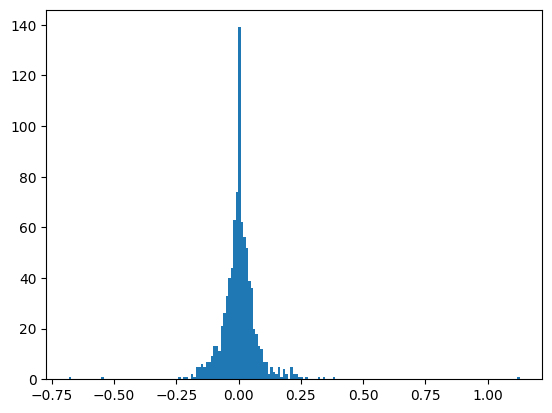

In [ ]:
tick_bars_plot = np.log(tick_bars.close/tick_bars.close.shift(1)).dropna()
bin_len = 0.01
plt.hist(tick_bars_plot, bins=np.arange(min(tick_bars_plot),max(tick_bars_plot)+bin_len, bin_len))
plt.show()

#### Volume Bars

Volume bars are sampled every time a pre-defined amount the the security’s units have been exchanged.

In [ ]:
def create_volume_bars(trades: pd.DataFrame, volume: int) -> pd.DataFrame:
    volume_bars_raw = trades.groupby(bar(np.cumsum(trades[DataType.SIZE]), volume)).agg({DataType.PRICE: 'ohlc', DataType.SIZE: 'sum'})
    volume_bars = volume_bars_raw.loc[:,DataType.PRICE]
    volume_bars['volume'] = volume_bars_raw.loc[:,DataType.SIZE]
    return volume_bars

traded_volume = 10
volume_bars = create_volume_bars(trades_df, traded_volume)

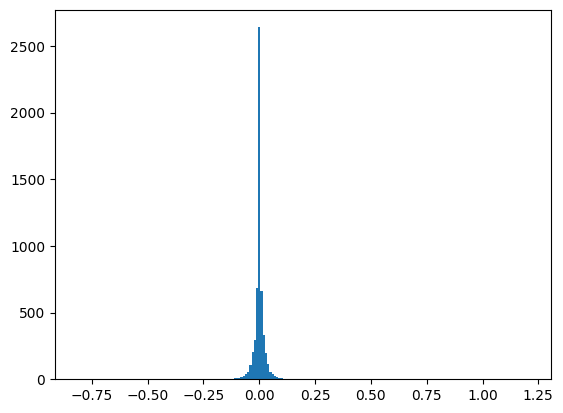

In [ ]:
volume_bars_plot = np.log(volume_bars.close/volume_bars.close.shift(1)).dropna()
bin_len = 0.01
plt.hist(volume_bars_plot, bins=np.arange(min(volume_bars_plot),max(volume_bars_plot)+bin_len, bin_len))
plt.show()

## 3. Classifying Trades using BVC

### 3.1 Running the algorithm

Our function takes either tick or volume bars to classify volumes. The number of transactions or traded volume can be individually specified.

In [ ]:
no_transactions = 5
tick_bars = create_tick_bars(trades_df, no_transactions)

traded_volume = 5
volume_bars = create_volume_bars(trades_df, traded_volume)

bvc = bulk_volume_classifier(ohlc_vol_bars=tick_bars, lookback=100)
bvc.loc[:,'close'] = tick_bars.close

bvc

,V_buy,V_sell,V_frac,close
0,NaN,NaN,NaN,3.86
5,NaN,NaN,NaN,3.65
10,NaN,NaN,NaN,3.65
15,NaN,NaN,NaN,3.75
20,NaN,NaN,NaN,2.56
...,...,...,...,...
17810,2.990371,5.009629,0.373796,33.89
17815,4.940416,3.059584,0.617552,34.56
17820,2.835185,2.164815,0.567037,34.88
17825,2.712003,3.287997,0.452001,34.66


### 3.2 Visualising our Results

Let's just a subset of the data.

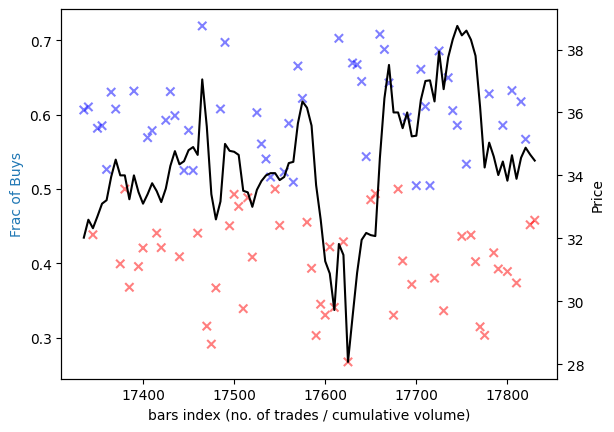

In [ ]:
subset = 100

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(bvc.index[-subset:], bvc.V_frac[-subset:], marker='x', color=np.where(bvc.V_frac[-subset:]>0.5, 'blue', 'red'), alpha=0.5)
ax2.plot(tick_bars.close[-subset:], 'k')

ax1.set_xlabel('bars index (no. of trades / cumulative volume)')
ax1.set_ylabel('Frac of Buys', color='tab:blue')
ax2.set_ylabel('Price', color='k')

plt.show()

### 3.3 Creating an Indicator

In [ ]:
def create_indicator(arr: np.ndarray) -> np.ndarray:
    """Takes numpy array [0,1] and normalises values between [-1,1]"""
    return 2 * arr - 1

def moving_average(indicator: pd.Series, n: int) -> pd.Series:
    """Takes indicator every time period, provides moving average"""
    return indicator.rolling(window=n).mean()

bvc['indicator'] = create_indicator(bvc.V_frac)
bvc['ma10'] = moving_average(bvc.indicator, 10)

### 3.4 Cleaning up our findings

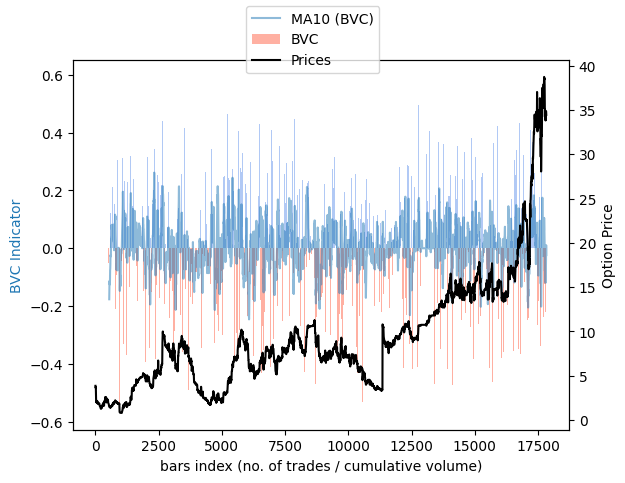

In [ ]:
subset = 10000

bvc_subset = bvc[-subset:]

fig, ax1 = plt.subplots()
# plot line chart on axis #1

ax1.bar(bvc_subset.index, bvc_subset.indicator, label='BVC', width=no_transactions, alpha=0.5, color=np.where(bvc_subset.indicator[-subset:]>0, 'cornflowerblue', 'tomato'))
ax1.plot(bvc_subset.index, bvc_subset.ma10, label='MA10 (BVC)', alpha=0.5)
# set up the 2nd axis
ax2 = ax1.twinx()
# plot bar chart on axis #2
ax2.plot(bvc_subset.index, bvc_subset.close, 'k-', label='Prices')
ax2.grid(False) # turn off grid #2

ax1.set_xlabel('bars index (no. of trades / cumulative volume)')
ax1.set_ylabel('BVC Indicator', color='tab:blue')
ax2.set_ylabel('Option Price', color='k')

fig.legend(loc=9)

plt.show()